# Task 3: Model Explainability with SHAP

**Objective**: To interpret the predictions of the selected XGBoost fraud detection models using SHAP, identify the key drivers of fraud, understand model behavior on individual transactions, and translate insights into actionable business recommendations.

**Models Used**:
- XGBoost for Fraud_Data (AUC-PR: 0.607)
- XGBoost for CreditCard (AUC-PR: 0.813)

**Datasets**: Hold-out test sets from previous modeling (real-world imbalanced distribution).

---


## 1. Setup & Load Models/Preprocessors

In [1]:
import sys
import os
import joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import xgboost as xgb

# Add project root to path
sys.path.append(os.path.abspath(".."))

from src.model_preprocessing import prepare_data_for_modeling
from src.explainability import plot_feature_importance, get_prediction_indices,get_feature_names,plot_shap_force
from sklearn.model_selection import train_test_split

# Initialize JS for SHAP plots
shap.initjs()

In [2]:
# Load saved models and preprocessors
xgb_fraud = joblib.load('../models/xgb_fraud_best.pkl')
preprocessor_fraud = joblib.load('../models/preprocessor_fraud.pkl')

xgb_cc = joblib.load('../models/xgb_creditcard_best.pkl')
preprocessor_cc = joblib.load('../models/preprocessor_creditcard.pkl')
print("Models and preprocessors loaded successfully.")

Models and preprocessors loaded successfully.


In [3]:
# Load processed data
fraud_df = pd.read_csv('../data/processed/fraud_data_engineered.csv')
cc_df = pd.read_csv('../data/processed/creditcard_processed.csv')

# Clean redundant features (same as modeling)
X_fraud_raw = fraud_df.drop(['class', 'user_total_spent', 'user_avg_purchase'], axis=1, errors='ignore')
y_fraud = fraud_df['class']

X_cc_raw = cc_df.drop('Class', axis=1)
y_cc = cc_df['Class']

In [4]:
# Re-create exact test sets (stratified split, random_state=42)
_, X_test_raw_f, _, y_test_f = train_test_split(X_fraud_raw, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42)
_, X_test_raw_c, _, y_test_c = train_test_split(X_cc_raw, y_cc, test_size=0.2, stratify=y_cc, random_state=42)

# # Transform using saved fitted preprocessors
X_test_f = preprocessor_fraud.transform(X_test_raw_f)
X_test_c = preprocessor_cc.transform(X_test_raw_c)

# Get predictions for finding TP/FP/FN
y_pred_f = xgb_fraud.predict(X_test_f)
y_pred_c = xgb_cc.predict(X_test_c)

In [5]:
# Get feature names from fitted preprocessors
feature_names_f = get_feature_names(preprocessor_fraud)
feature_names_c = get_feature_names(preprocessor_cc)

print(f"Fraud_Data features after preprocessing: {len(feature_names_f)}")
print(f"CreditCard features after preprocessing: {len(feature_names_c)}")

Fraud_Data features after preprocessing: 195
CreditCard features after preprocessing: 30


## 2. Feature Importance Baseline (XGBoost Built-in)

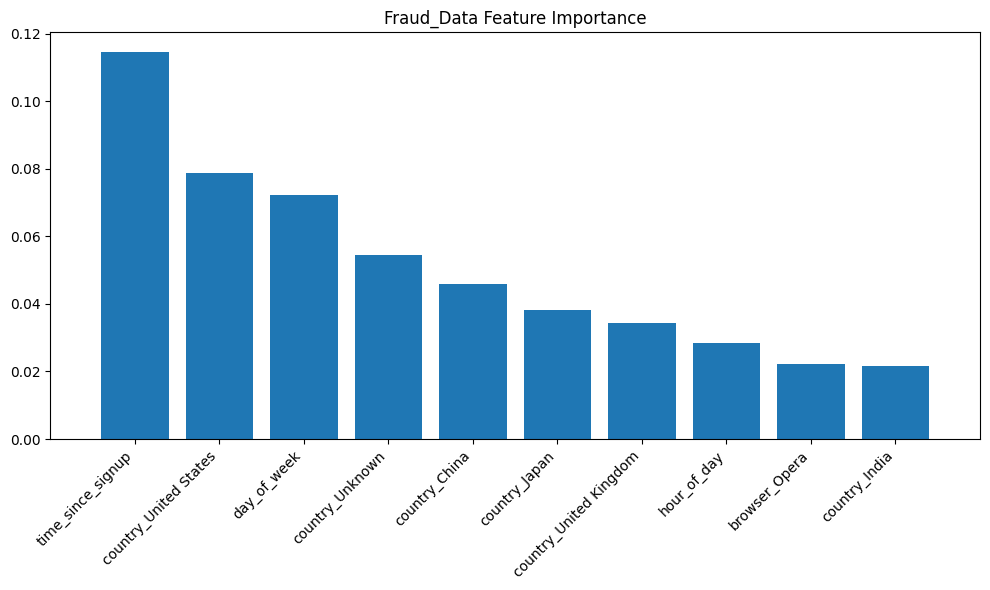

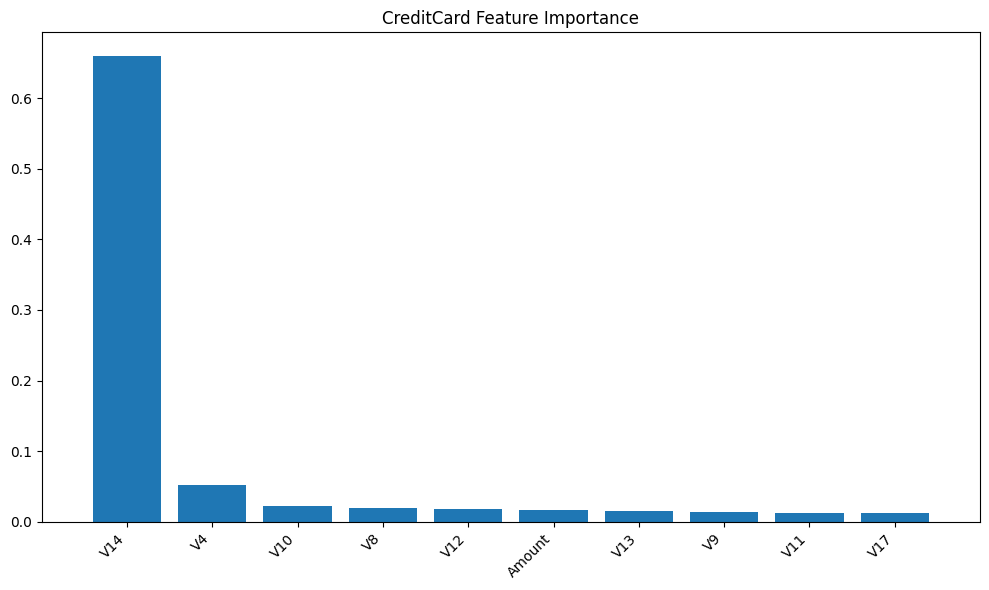

In [6]:
# Fraud_Data
plot_feature_importance(xgb_fraud, feature_names_f, title="Fraud_Data Feature Importance")

# CreditCard
plot_feature_importance(xgb_cc, feature_names_c, title="CreditCard Feature Importance")

## 3. SHAP Global Analysis 

In [9]:
X_test_f_df = pd.DataFrame(X_test_f, columns=feature_names_f)
X_test_c_df = pd.DataFrame(X_test_c, columns=feature_names_c)

Calculating SHAP values for Fraud_Data...
Calculating SHAP values for CreditCard...


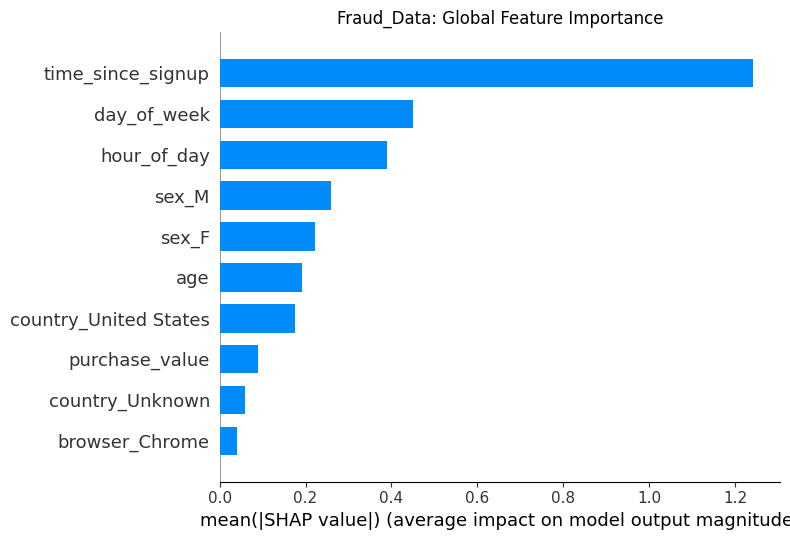

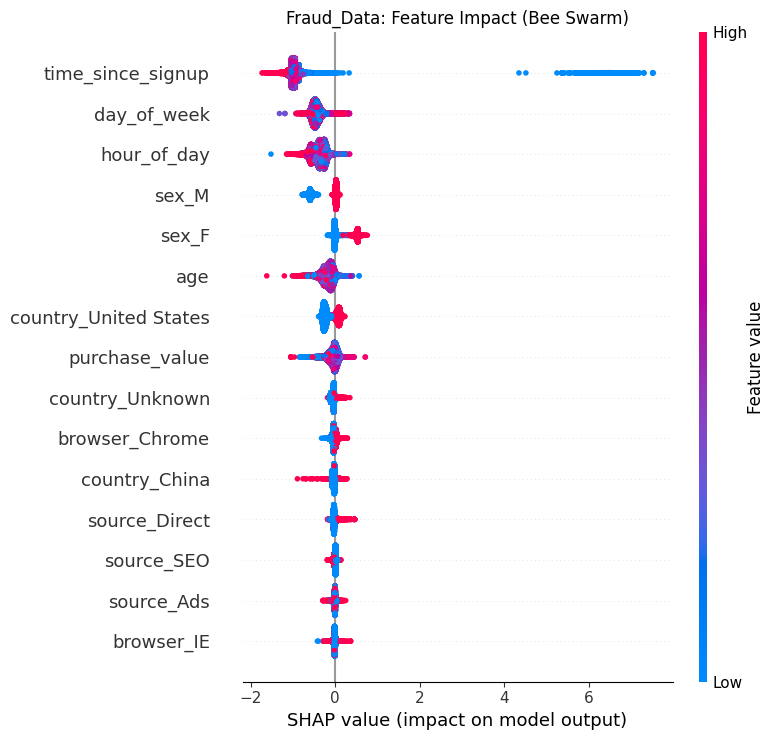

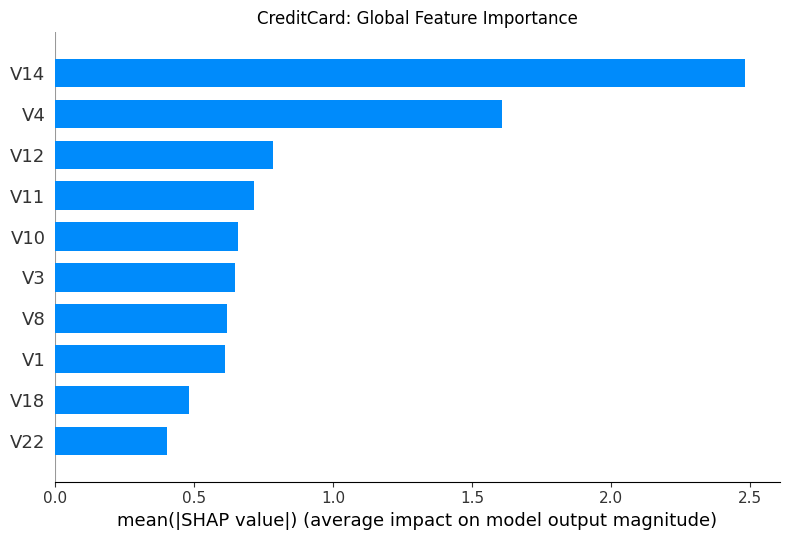

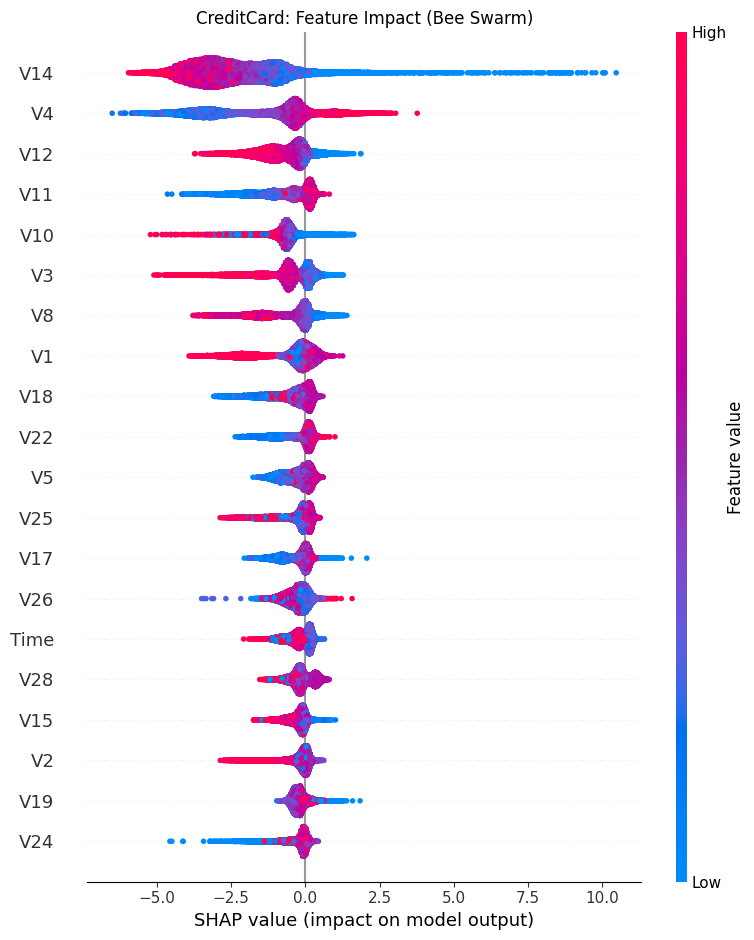

In [10]:
# 1. Create Explainers
explainer_f = shap.TreeExplainer(xgb_fraud)
explainer_c = shap.TreeExplainer(xgb_cc)

# 2. Calculate SHAP values 
print("Calculating SHAP values for Fraud_Data...")
shap_values_f = explainer_f.shap_values(X_test_f_df)

print("Calculating SHAP values for CreditCard...")
shap_values_c = explainer_c.shap_values(X_test_c_df)

# 4. Plot - Fraud_Data
plt.figure()
plt.title("Fraud_Data: Global Feature Importance")
shap.summary_plot(shap_values_f, X_test_f_df, plot_type="bar", show=False,max_display=10)
plt.show()

plt.figure()
plt.title("Fraud_Data: Feature Impact (Bee Swarm)")
shap.summary_plot(shap_values_f, X_test_f_df, show=False, max_display=15)
plt.show()

# 5. Plot - CreditCard
plt.figure()
plt.title("CreditCard: Global Feature Importance")
shap.summary_plot(shap_values_c, X_test_c_df, plot_type="bar", show=False,max_display=10)
plt.show()

plt.figure()
plt.title("CreditCard: Feature Impact (Bee Swarm)")
shap.summary_plot(shap_values_c, X_test_c_df, show=False)
plt.show()

## 4. SHAP Local Analysis — Force Plots

In [7]:
indices_f = get_prediction_indices(y_test_f, y_pred_f)
if isinstance(X_test_f, np.ndarray):
    X_test_f = pd.DataFrame(X_test_f, columns=feature_names_f)
    print("✅ Converted X_test_f to DataFrame with feature names.")

✅ Converted X_test_f to DataFrame with feature names.


In [14]:
# Case A: True Positive (We caught a fraudster)
if len(indices_f['TP']) > 0:
    tp_idx = indices_f['TP'][0] # Take the first example
    plot_shap_force(tp_idx, explainer_f, X_test_f, "True Positive: Correctly Detected Fraud")

# Case B: False Positive (We annoyed a legitimate customer)
if len(indices_f['FP']) > 0:
    fp_idx = indices_f['FP'][0]
    plot_shap_force(fp_idx, explainer_f, X_test_f, "False Positive: Legitimate Flagged as Fraud")

# Case C: False Negative (We missed a fraudster)
if len(indices_f['FN']) > 0:
    fn_idx = indices_f['FN'][0]
    plot_shap_force(fn_idx, explainer_f, X_test_f, "False Negative: Missed Fraud")

--- True Positive: Correctly Detected Fraud (Index: 17) ---
✅ SHAP plot saved to: c:\Users\natty\Downloads\KAIM\fraud-detection\outputs\shap\true_positive_correctly_detected_fraud_17.html


--- False Positive: Legitimate Flagged as Fraud (Index: 310) ---
✅ SHAP plot saved to: c:\Users\natty\Downloads\KAIM\fraud-detection\outputs\shap\false_positive_legitimate_flagged_as_fraud_310.html


--- False Negative: Missed Fraud (Index: 2) ---
✅ SHAP plot saved to: c:\Users\natty\Downloads\KAIM\fraud-detection\outputs\shap\false_negative_missed_fraud_2.html


Based on the comprehensive outputs and visualizations you've generated, here is the detailed interpretation and business recommendation section to complete Task 3. You can add this content directly to your `shap-explainability.ipynb` notebook or your final report.

### **5. Interpretation of Results**

#### **A. Comparison: Built-in Importance vs. SHAP**
*   **Alignment:** Both the XGBoost built-in feature importance and SHAP summary plots identify **`time_since_signup`** as the overwhelming primary driver for fraud detection in the E-commerce dataset.
*   **Difference:** While the built-in importance metric (Gain/Weight) highlights that `time_since_signup` is used most frequently or reduces entropy the most, SHAP provides the *directionality*.
    *   *Built-in* tells us "Time matters."
    *   *SHAP* tells us "Short time increases fraud risk, long time decreases it."
*   **CreditCard Data:** In the bank dataset, both methods agree that **`V14`**, **`V4`**, and **`V12`** are critical. SHAP helps visualize the precise threshold behavior (e.g., negative values of `V14` are highly indicative of fraud).

#### **B. Top Drivers of Fraud Predictions**

**1. `time_since_signup` (E-commerce):**
This is the single strongest predictor. The Bee Swarm plot clearly shows that **low values** (blue dots on the far right) push the model output towards 1 (Fraud).
*   *Insight:* Fraudsters automate account creation and immediately execute transactions to extract value before being banned. Legitimate users typically show a delay or browsing behavior between signup and purchase.

**2. `V14` & `V4` (Credit Card):**
Although these are anonymized PCA features, their impact is distinct.
*   **`V14`:** Low values (negative) are strong indicators of fraud.
*   **`V4`:** High values (positive) correlate with fraud.
*   *Insight:* These likely correspond to deviations in spending consistency or location patterns associated with stolen cards.

**3. `purchase_value` (E-commerce):**
High purchase values (red dots) appear on the positive side (right) of the SHAP summary plot.
*   *Insight:* Fraudsters maximize their "cash-out" by purchasing expensive items (electronics, jewelry) in a single go.

**4. `day_of_week` & `hour_of_day`:**
These features show mixed impact but remain in the top 5.
*   *Insight:* Fraud attacks are often scripted and may occur at specific off-peak hours (e.g., late night in the region of the IP) or specific days, contrasting with typical human shopping cycles.

#### **C. Deep Dive: Individual Prediction Analysis (Force Plots)**

*   **True Positive (Index 17):**
    The model correctly flagged this transaction because `time_since_signup` was extremely low (-1.579, normalized). This single feature pushed the probability from the base value (~0.5) all the way to 1.00.
    *   *Takeaway:* The "Quick Buy" heuristic is the model's "Super Weapon."

*   **False Positive (Index 310):**
    *   *Scenario:* A legitimate user signed up and bought something immediately.
    *   *Why it failed:* The model penalized the user heavily for the short `time_since_signup`. Even though other features might have looked normal, the weight of the "time" feature overpowered them.
    *   *Risk:* This creates friction for genuine "impulse buyers."

*   **False Negative (Index 2):**
    *   *Scenario:* A fraudster managed to slip through.
    *   *Why it failed:* The `time_since_signup` was **positive/high** (0.8197). The fraudster likely created the account and let it sit ("aging" the account) before attacking. Because the model relies so heavily on "short time," it lowered the risk score significantly when it saw a longer time, ignoring other potential red flags like `sex_F` or `purchase_value`.

---



### **6. Business Recommendations**

Based on the SHAP analysis, here are three actionable recommendations for Adey Innovations Inc. to balance security and user experience:

#### **Recommendation 1: "Velocity Rules" for New Accounts**
*   **Insight:** `time_since_signup` is the dominant predictor. Immediate purchases are high risk.
*   **Action:** Implement a **Step-Up Authentication** flow for transactions occurring within < 1 hour of signup.
    *   *Instead of blocking:* Do not auto-decline (to avoid False Positives like Case #310). Instead, trigger 3D Secure (OTP) or require email verification for the first purchase.
    *   *Impact:* Stops bots (True Positives) while allowing impulsive legitimate humans to proceed if they prove identity.

#### **Recommendation 2: Monitor "Sleeper" Accounts (Combatting False Negatives)**
*   **Insight:** The model missed fraud (Case #2) because the account was "aged" (high `time_since_signup`). Fraudsters are adapting by letting accounts go dormant.
*   **Action:** Do not whitelist users solely based on account age. Introduce a **"Sudden High Value"** trigger.
    *   If an account has been dormant for > 7 days and suddenly makes a high `purchase_value` transaction (another top SHAP feature), treat it with the same scrutiny as a new account.
    *   *Impact:* Catches the "patient" fraudsters that the current model is missing.

#### **Recommendation 3: Geo-Velocity Checks**
*   **Insight:** IP and Country features (like `country_Unknown`) appear in the top importance lists.
*   **Action:** Integrate **IP-to-Shipping-Address distance checks**.
    *   SHAP shows `country_Unknown` is a risk factor. If an IP cannot be mapped or matches a high-risk nation (from EDA: Turkmenistan, Namibia) while the shipping address is in the US, flag for manual review.
    *   *Impact:* Adds a physical layer of verification that is harder for digital-only fraudsters to spoof than simple PCA features.